# GMM實際案例

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [2]:
# 數據 => 在弗里蒙特橋的兩邊，隨著不同時間單車借用次數(year : 2012 ~ 2017)
data = pd.read_csv ('Fremont.csv' , index_col = 'Date' , parse_dates = True)
data.head(10)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0
2012-10-03 05:00:00,21.0,10.0
2012-10-03 06:00:00,105.0,50.0
2012-10-03 07:00:00,257.0,95.0
2012-10-03 08:00:00,291.0,146.0


## 先看一下資料長什麼樣子

C:\Users\peng\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

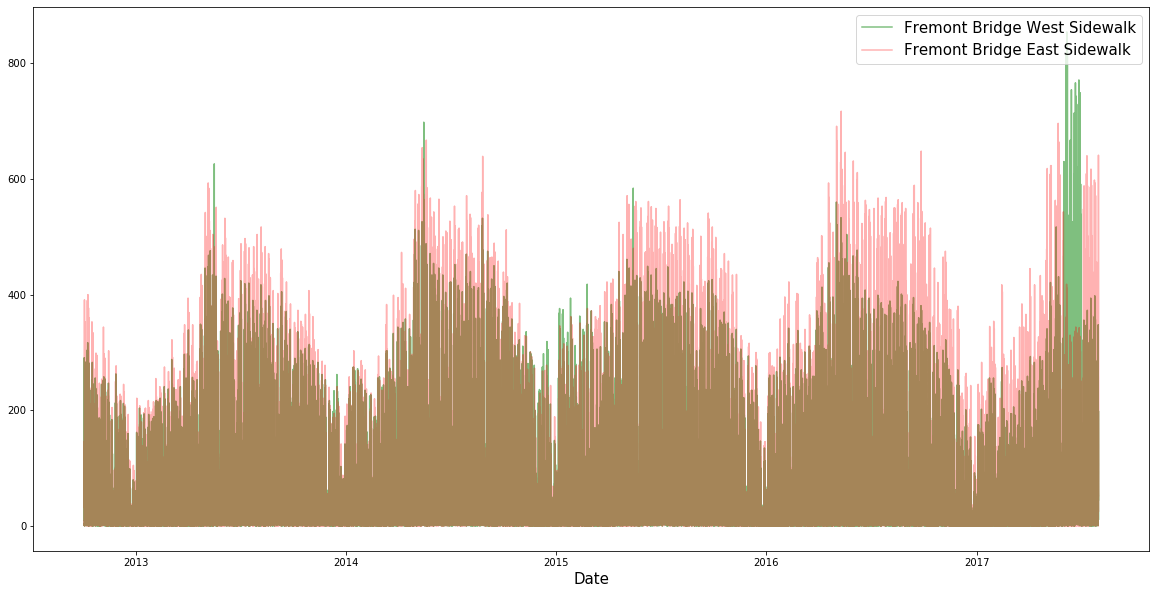

In [3]:
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.plot(data.index , data['Fremont Bridge West Sidewalk'] , color = 'green' , alpha = 0.5 , label = 'Fremont Bridge West Sidewalk')
ax.plot(data.index , data['Fremont Bridge East Sidewalk'] , color = 'red' , alpha = 0.3 , label = 'Fremont Bridge East Sidewalk')
ax.legend(loc = 'upper right' , fontsize = 15)
ax.set_xlabel('Date' , fontsize = 15)  

數據重新採樣，按日進行計算

Text(0.5, 1.0, 'Resample by Day')

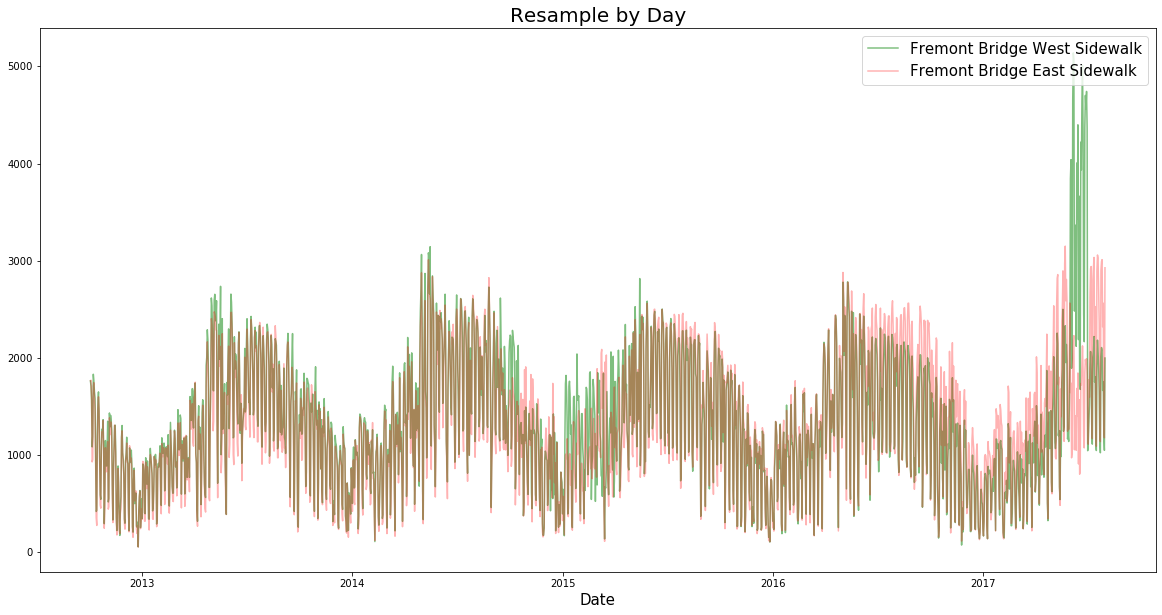

In [4]:
resample_day = data.resample('d').sum()

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.plot(resample_day.index , resample_day['Fremont Bridge West Sidewalk'] , color = 'green' , alpha = 0.5 , label = 'Fremont Bridge West Sidewalk')
ax.plot(resample_day.index , resample_day['Fremont Bridge East Sidewalk'] , color = 'red' , alpha = 0.3 , label = 'Fremont Bridge East Sidewalk')
ax.legend(loc = 'upper right' , fontsize = 15)
ax.set_xlabel('Date' , fontsize = 15)  
ax.set_title('Resample by Day' , fontsize = 20)  

數據重新採樣，按周進行計算

Text(0.5, 1.0, 'Resample by Week')

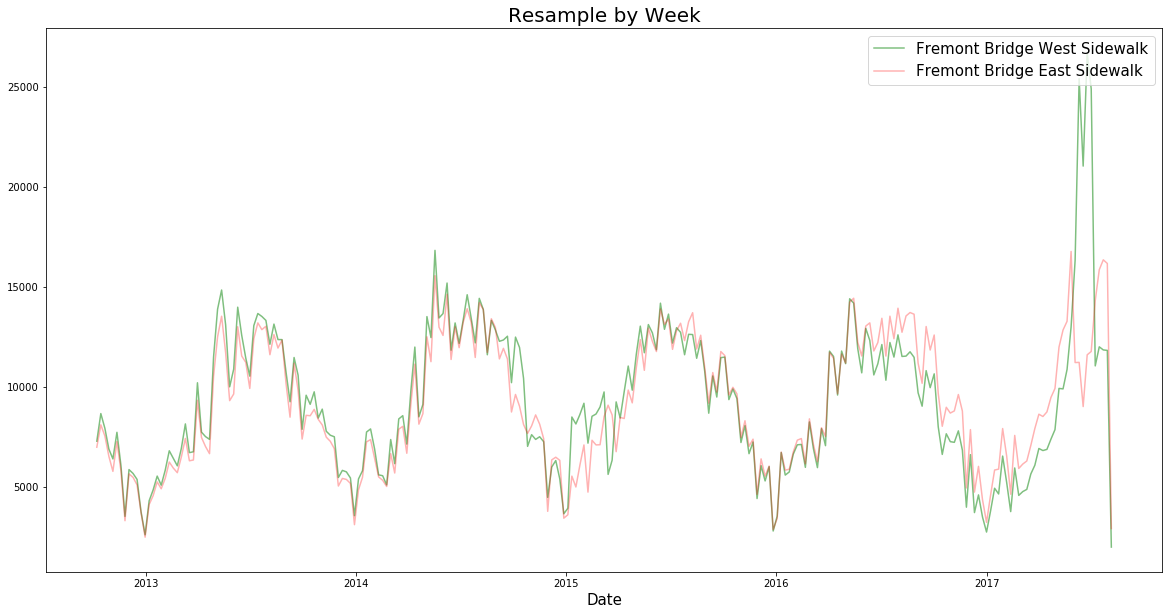

In [5]:
resample_week = data.resample('w').sum()

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.plot(resample_week.index , resample_week['Fremont Bridge West Sidewalk'] , color = 'green' , alpha = 0.5 , label = 'Fremont Bridge West Sidewalk')
ax.plot(resample_week.index , resample_week['Fremont Bridge East Sidewalk'] , color = 'red' , alpha = 0.3 , label = 'Fremont Bridge East Sidewalk')
ax.legend(loc = 'upper right' , fontsize = 15)
ax.set_xlabel('Date' , fontsize = 15)  
ax.set_title('Resample by Week' , fontsize = 20)  

從上面3個圖可以看出單車借用量在年中會達到最高峰，而年初與年尾為單車借用量的低谷

Text(0.5, 1.0, 'Groupby by Hour')

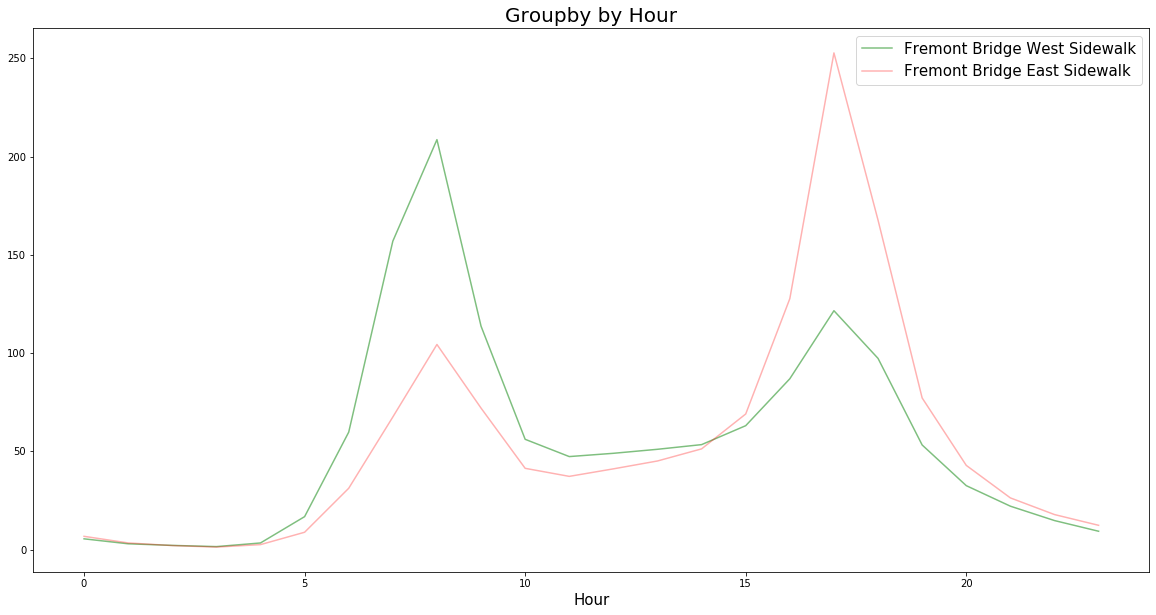

In [6]:
# 將相同時間(1點、2點、.....)的data取出來，在做平均
groupby_time = data.groupby(data.index.hour).mean()

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.plot(groupby_time.index , groupby_time['Fremont Bridge West Sidewalk'] , color = 'green' , alpha = 0.5 , label = 'Fremont Bridge West Sidewalk')
ax.plot(groupby_time.index , groupby_time['Fremont Bridge East Sidewalk'] , color = 'red' , alpha = 0.3 , label = 'Fremont Bridge East Sidewalk')
ax.legend(loc = 'upper right' , fontsize = 15)
ax.set_xlabel('Hour' , fontsize = 15)  
ax.set_title('Groupby by Hour' , fontsize = 20)  

單車借用量大概在上午7 ~ 8點與下午3 ~ 4點為最高峰

In [7]:
# pivot table 我們已經知道東邊跟西邊的數據，先在把東邊與西邊的數據加起來變成total
# 再看能不能用GMM模型將東邊與西邊的數據預測出來
data.columns = ['west' , 'east']
data['total_num'] = data['west'] + data['east']

# data_pivoted顯示每一個日期中，所有時刻的單車借用數目
data_pivoted = data.pivot_table('total_num' , index = data.index.date , columns = data.index.time) 
data_pivoted.iloc[:10 , :]

,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
2012-10-03,13.0,10.0,2.0,5.0,7.0,31.0,155.0,352.0,437.0,276.0,...,128.0,164.0,315.0,583.0,380.0,128.0,80.0,63.0,49.0,17.0
2012-10-04,18.0,3.0,9.0,3.0,8.0,26.0,142.0,319.0,418.0,241.0,...,119.0,147.0,275.0,507.0,378.0,164.0,83.0,70.0,46.0,41.0
2012-10-05,11.0,8.0,7.0,4.0,9.0,25.0,105.0,319.0,370.0,212.0,...,125.0,164.0,310.0,434.0,316.0,115.0,68.0,42.0,36.0,32.0
2012-10-06,15.0,15.0,9.0,3.0,5.0,5.0,27.0,33.0,105.0,114.0,...,203.0,211.0,183.0,180.0,96.0,78.0,43.0,33.0,34.0,34.0
2012-10-07,11.0,17.0,3.0,6.0,3.0,9.0,17.0,26.0,69.0,103.0,...,241.0,231.0,225.0,191.0,113.0,49.0,55.0,47.0,18.0,16.0
2012-10-08,9.0,4.0,5.0,5.0,5.0,23.0,137.0,327.0,457.0,278.0,...,121.0,167.0,252.0,604.0,365.0,168.0,94.0,63.0,29.0,24.0
2012-10-09,12.0,3.0,4.0,8.0,9.0,31.0,153.0,368.0,462.0,275.0,...,108.0,134.0,244.0,597.0,396.0,163.0,85.0,64.0,34.0,23.0
2012-10-10,15.0,3.0,3.0,4.0,5.0,25.0,149.0,340.0,435.0,255.0,...,93.0,130.0,230.0,532.0,331.0,145.0,86.0,62.0,36.0,23.0
2012-10-11,21.0,10.0,13.0,2.0,12.0,12.0,43.0,304.0,404.0,189.0,...,108.0,143.0,270.0,517.0,299.0,149.0,104.0,71.0,48.0,33.0
2012-10-12,17.0,13.0,5.0,7.0,5.0,14.0,87.0,183.0,268.0,145.0,...,65.0,113.0,165.0,304.0,178.0,79.0,38.0,26.0,14.0,24.0


Text(0.5, 0, 'Time')

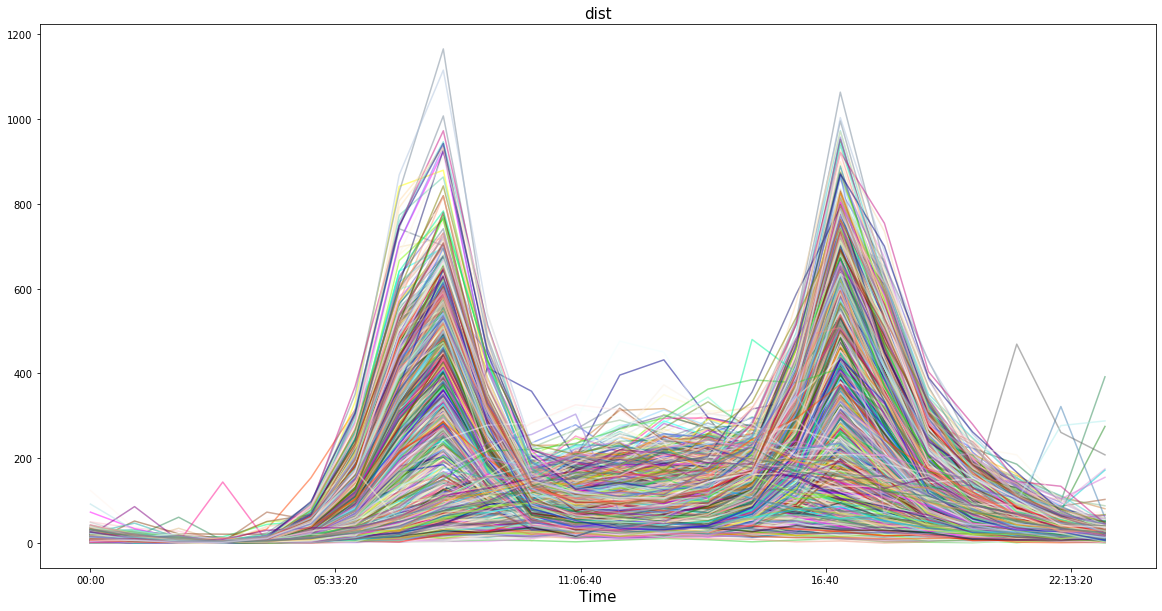

In [8]:
# 觀察每日單車的借用總量在24個小時的分布情況
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
color_list = list(matplotlib.colors.cnames.values()) # color_list長度 => 148

color_count = 0
for i in range(0 , len(data_pivoted)):
    ax.plot(data_pivoted.columns , data_pivoted.iloc[i , :] , color = color_list[color_count] , alpha = 0.5 , label = 'Fremont Bridge West Sidewalk')
    
    # 因為color_list長度只有148，所以當i超過148，重新讓color_count為0，使迴圈不致中斷
    color_count += 1
    if color_count == len(color_list): color_count = 0 

ax.set_title('dist' , fontsize = 15)        
ax.set_xlabel('Time' , fontsize = 15)  

可以從上面的圖看出來，隨時間的變化，腳踏車的借用數量有兩種不同的分布<br>
而現在我們試著將這兩種分布用聚類算法分離出來

In [9]:
# X有1763天、每個小時的腳踏車的借用輛= > 1763筆數據，每筆數據有24個特徵(24小時)
# 現在以這1763筆數據作為訓練資料，利用聚類算法將上圖兩種分布分離出來

X = data_pivoted.fillna(0).values 
print('欲分析資料的shape : {}'.format(X.shape))

欲分析資料的shape : (1763, 24)


Text(0, 0.5, 'PCA_2')

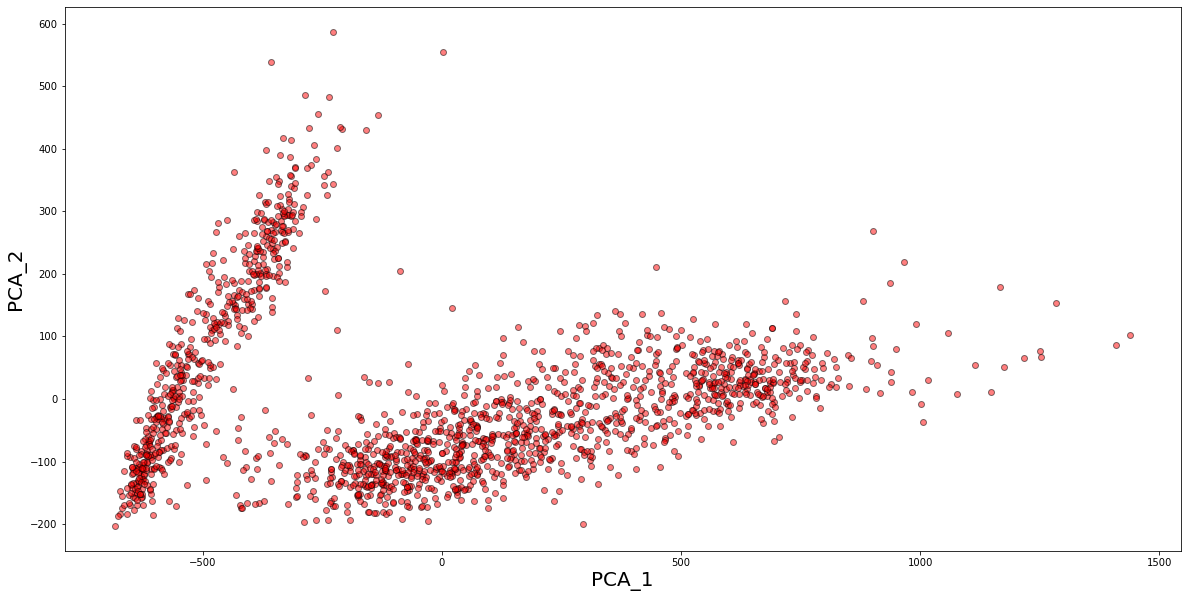

In [10]:
X_pca = PCA(2).fit_transform(X)

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.scatter(X_pca[: , 0] , X_pca[: , 1] , color = 'red' , alpha = 0.5 , edgecolor = 'black')
ax.set_xlabel('PCA_1' , fontsize = 20)
ax.set_ylabel('PCA_2' , fontsize = 20)

使用PCA轉到2為平面上可以發現data明顯分為2群

Text(0, 0.5, 'TSNE_2')

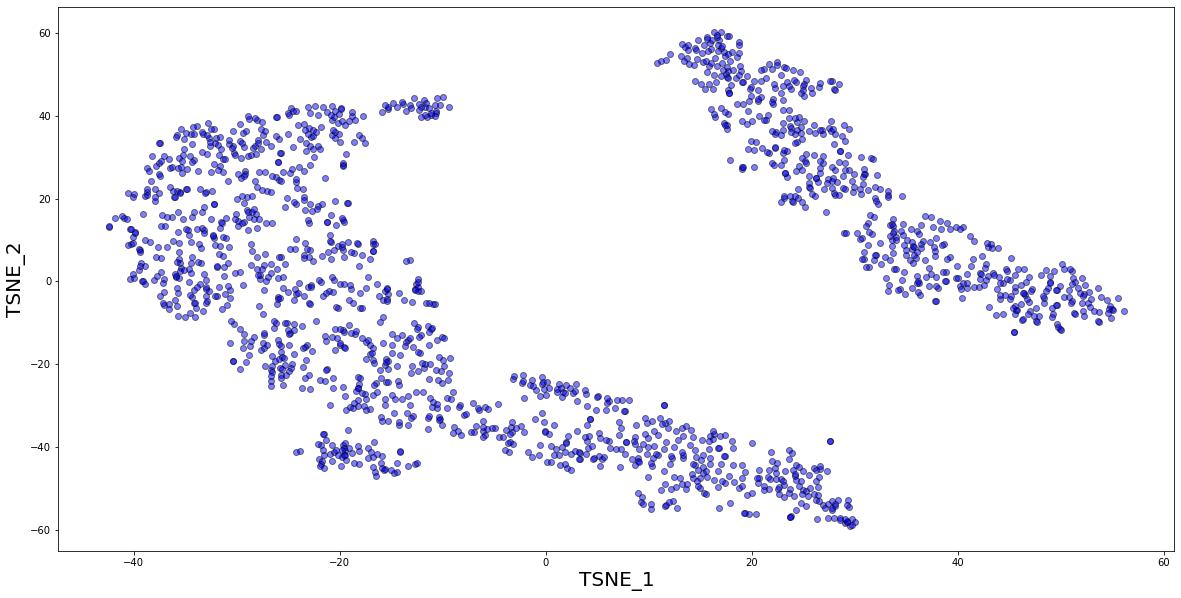

In [11]:
tsne_model = TSNE(n_components = 2 , verbose = 0 , random_state = 0 , n_iter = 1000)

X_tsne = tsne_model.fit_transform(X)
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.scatter(X_tsne[: , 0] , X_tsne[: , 1] , color = 'blue' , alpha = 0.5 , edgecolor = 'black')
ax.set_xlabel('TSNE_1' , fontsize = 20)
ax.set_ylabel('TSNE_2' , fontsize = 20)

使用TSNE轉到2為平面上也可以發現data明顯分為2群

In [12]:
# 用GaussianMixture model將data分成2個class，假設每筆數據是從2種Gaussian dist產生的
gmm = GaussianMixture(n_components = 2) 
gmm.fit(X)
labels_prob = gmm.predict_proba(X)

# labels_prob的第1個column代表數據是從第1種Gaussian dist產生的機率
# labels_prob的第2個column代表數據是從第2種Gaussian dist產生的機率
labels_prob = pd.DataFrame(labels_prob)
labels_prob.columns = ['class_1' , 'class_2']
labels_prob.head(10)

,class_1,class_2
0,1.000000e+00,4.272007e-157
1,1.000000e+00,2.976066e-125
2,1.000000e+00,1.004613e-101
3,3.354883e-13,1.000000e+00
4,6.806229e-30,1.000000e+00
5,1.000000e+00,1.816134e-153
6,1.000000e+00,4.430012e-173
7,1.000000e+00,5.927064e-153
8,1.000000e+00,2.441862e-103
9,1.000000e+00,3.959659e-45


In [13]:
# 使用GaussianMixture model預測data的label
labels = gmm.predict(X)

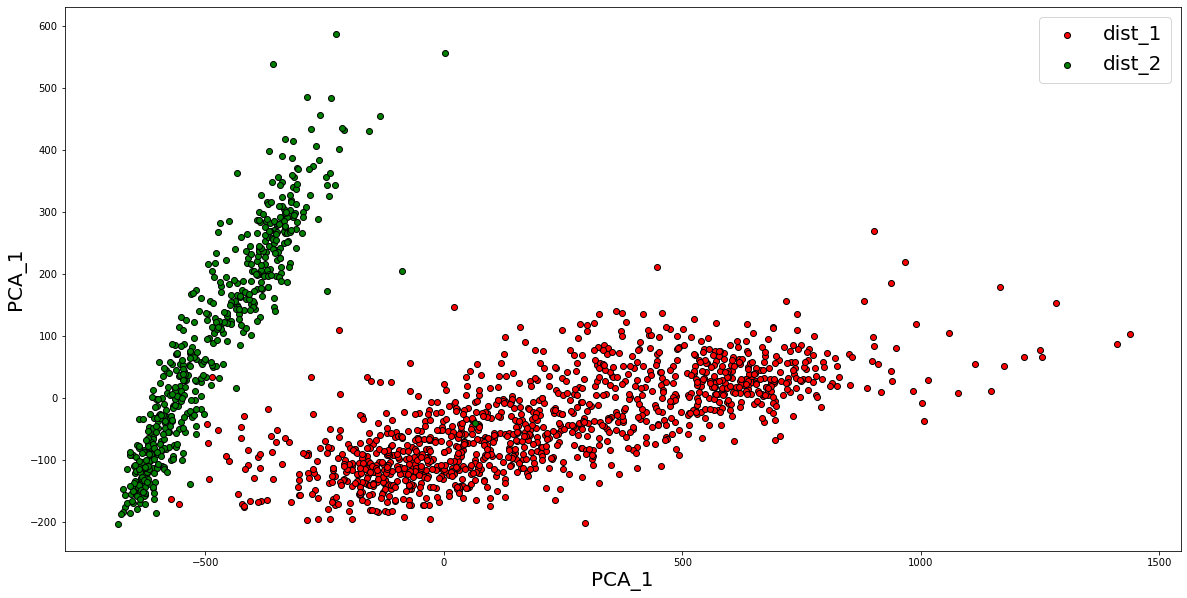

In [14]:
# 看一下預測的label在2維平面(PCA)的分布情況

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
label_dict = {0 : 'dist_1' , 1: 'dist_2'}

for lab , col in zip([0 , 1] , ['red' , 'green']):
     ax.scatter(X_pca[labels == lab , 0] ,
                X_pca[labels == lab , 1] ,
                label = label_dict[lab] ,
                c = col ,
                edgecolor = 'black')
        
ax.set_xlabel('PCA_1' , fontsize = 20)
ax.set_ylabel('PCA_1' , fontsize = 20)
ax.legend(loc = 'best' , fontsize = 20)

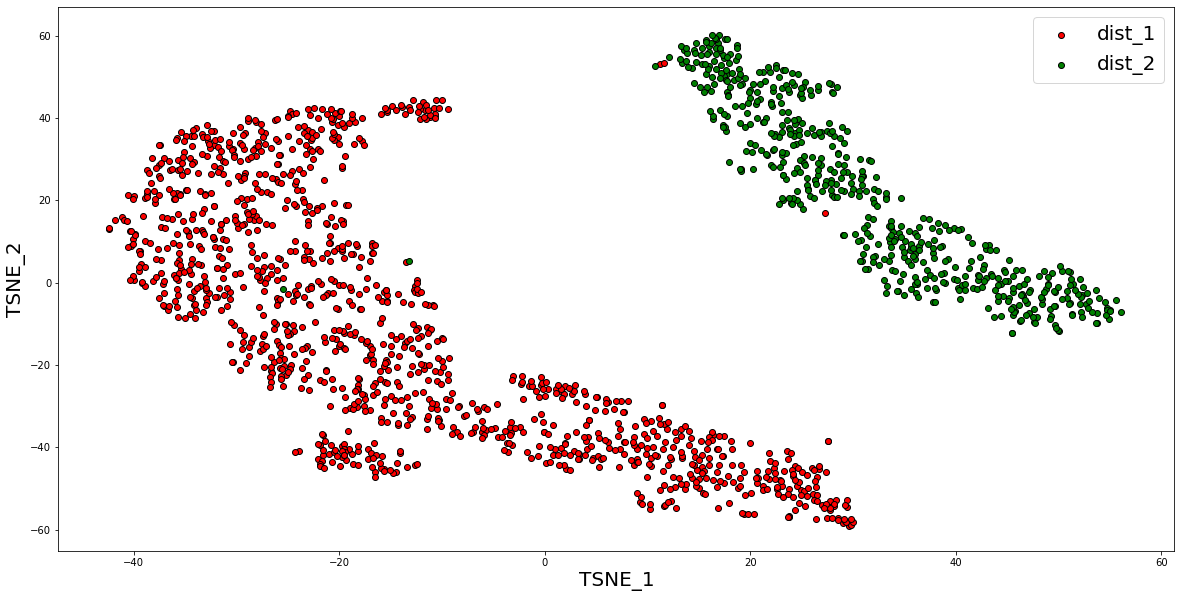

In [15]:
# 看一下預測的label在2維平面(TSNE)的分布情況

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
label_dict = {0 : 'dist_1' , 1: 'dist_2'}

for lab , col in zip([0 , 1] , ['red' , 'green']):
     ax.scatter(X_tsne[labels == lab , 0] ,
                X_tsne[labels == lab , 1] ,
                label = label_dict[lab] ,
                c = col ,
                edgecolor = 'black')
        
ax.set_xlabel('TSNE_1' , fontsize = 20)
ax.set_ylabel('TSNE_2' , fontsize = 20)
ax.legend(loc = 'best' , fontsize = 20)

Text(0.5, 0, 'Time')

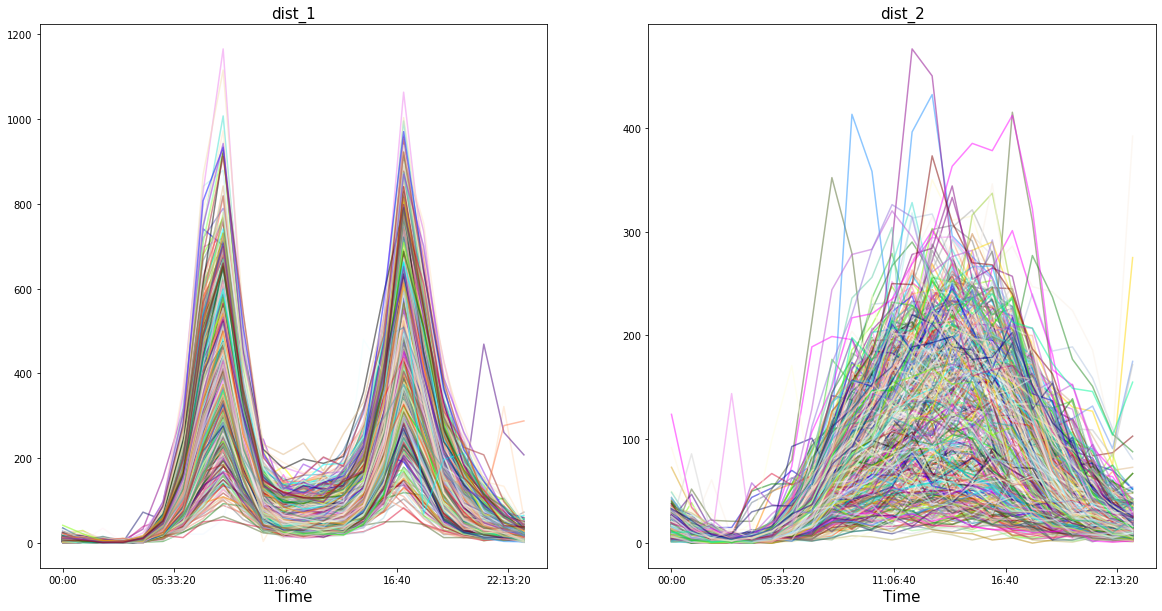

In [16]:
# 看一下GaussianMixture model預測每日單車借用量的label是否能正確對應兩種不同的時間分布
fig , ax = plt.subplots(1 , 2 , figsize = (20 , 10))
color_list = list(matplotlib.colors.cnames.values()) # color_list長度 => 148

# 第1種分布
color_count = 0
data_pivoted_dist_1 = data_pivoted.loc[labels == 0]
for i in range(0 , len(data_pivoted_dist_1)):
    ax[0].plot(data_pivoted_dist_1.columns , data_pivoted_dist_1.iloc[i , :] , color = color_list[color_count] , alpha = 0.5 , label = 'Fremont Bridge West Sidewalk')
    
    # 因為color_list長度只有148，所以當i超過148，重新讓color_count為0，使迴圈不致中斷
    color_count += 1
    if color_count == len(color_list): color_count = 0 

ax[0].set_title('dist_1' , fontsize = 15)        
ax[0].set_xlabel('Time' , fontsize = 15)  

# 第2種分布
color_count = 0
data_pivoted_dist_2 = data_pivoted.loc[labels == 1]
for i in range(0 , len(data_pivoted_dist_2)):
    ax[1].plot(data_pivoted_dist_2.columns , data_pivoted_dist_2.iloc[i , :] , color = color_list[color_count] , alpha = 0.5 , label = 'Fremont Bridge West Sidewalk')
    
    # 因為color_list長度只有148，所以當i超過148，重新讓color_count為0，使迴圈不致中斷
    color_count += 1
    if color_count == len(color_list): color_count = 0 

ax[1].set_title('dist_2' , fontsize = 15)        
ax[1].set_xlabel('Time' , fontsize = 15)          

看來用GaussianMixture model確實能將兩種單車借用量的時間分布分離出來